# Experiments with Similarity Encoders
## ...to show that SimEc can create similarity preserving embeddings for linear and non-linear similarities (like kernel PCA)
In this iPython Notebook are some examples to illustrate the potential of Similarity Encoders (SimEc) for creating similarity preserving embeddings. For further details and theoretical background on this new neural network architecture, please refer to the corresponding paper.

The notebook is structured as follows: After a short toy example, we present several experiments performed on the sklearn handwritten digits dataset (a small real world dataset which works great to quickly test some things out). Then we present the results on the MNIST and 20 newsgroups datasets reported in the original paper.

In [1]:
from __future__ import unicode_literals, division, print_function, absolute_import
from builtins import range
import numpy as np
np.random.seed(28)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA, KernelPCA
from sklearn.random_projection import SparseRandomProjection
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits, fetch_mldata, fetch_20newsgroups
import tensorflow as tf
tf.set_random_seed(28)
import keras

# find nlputils at https://github.com/cod3licious/nlputils
from nlputils.features import FeatureTransform, features2mat

from simec import SimilarityEncoder
from utils import center_K, check_embed_match, check_similarity_match
from utils_datasets import load_dataset
from utils_plotting import get_colors, plot2d, plot3d, plot_digits, plot_mnist, plot_20news

%matplotlib inline
%load_ext autoreload
%autoreload 2
# set this to True if you want to save the figures from the paper
savefigs = False

/home/franzi/anaconda2/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Toy Dataset: 3 Circles
Sanity check on an artificially generated toy dataset: Linear similarity encoders reach the same solution as PCA/linear kPCA (up to a rotation and scaling) and nicely map the test examples where they belong.

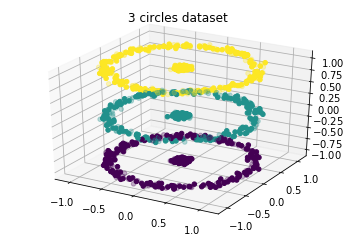

In [2]:
n_train = 1000
n_test = 500
dataset = '3_circles'
# get training and test data
X, Y_plot = load_dataset(dataset, n_train, 3)
X_test, Y_plot_test = load_dataset(dataset, n_test, 5)
ss = StandardScaler(with_std=False)
X = ss.fit_transform(X)
X_test = ss.transform(X_test)
# plot the original data
plot3d(X, Y_plot, X_test, Y_plot_test, title='%s dataset' % dataset.replace('_', ' '))

similarity approximation       : msqe: 0.0629632072 ; r^2: 0.8971205805 ; rho: 0.9186299240
similarity approximation (test): msqe: 0.0725416555 ; r^2: 0.8727695604 ; rho: 0.8905702688


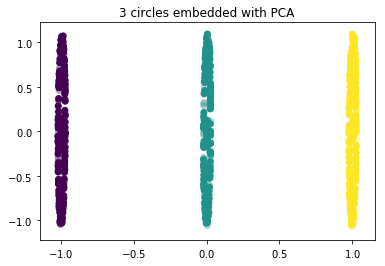

In [3]:
# simple 2D PCA solution
pca = PCA(n_components=2)
X_embed = pca.fit_transform(X)
X_embed_test = pca.transform(X_test)
plot2d(X_embed, Y_plot, X_embed_test, Y_plot_test, 
       title='%s embedded with PCA' % dataset.replace('_', ' '))
print("similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, center_K(np.dot(X, X.T))))
print("similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_test, center_K(np.dot(X_test, X_test.T))))

Epoch 1/25
1000/1000 [==============================] - 1s 605us/step - loss: 0.8715
Epoch 2/25
1000/1000 [==============================] - 0s 84us/step - loss: 0.6392
Epoch 3/25
1000/1000 [==============================] - 0s 86us/step - loss: 0.3487
Epoch 4/25
1000/1000 [==============================] - 0s 89us/step - loss: 0.2103
Epoch 5/25
1000/1000 [==============================] - 0s 97us/step - loss: 0.1595
Epoch 6/25
1000/1000 [==============================] - 0s 84us/step - loss: 0.1347
Epoch 7/25
1000/1000 [==============================] - 0s 94us/step - loss: 0.1232
Epoch 8/25
1000/1000 [==============================] - 0s 102us/step - loss: 0.1180
Epoch 9/25
1000/1000 [==============================] - 0s 92us/step - loss: 0.1155
Epoch 10/25
1000/1000 [==============================] - 0s 95us/step - loss: 0.1143
Epoch 11/25
1000/1000 [==============================] - 0s 102us/step - loss: 0.1137
Epoch 12/25
1000/1000 [==============================] - 0s 86us/step -

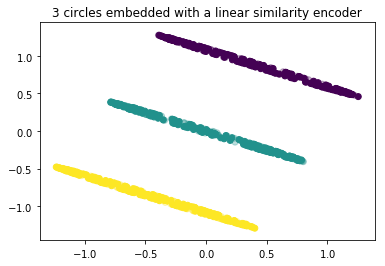

In [4]:
# similarity encoder no activation function, linear similarities as targets
K_lin = center_K(np.dot(X, X.T))
simec = SimilarityEncoder(X.shape[1], 2, K_lin.shape[1], l2_reg_emb=0.01, s_ll_reg=0.5, S_ll=K_lin, opt=keras.optimizers.Adamax(lr=0.01))
simec.fit(X, K_lin)
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot2d(X_embeds, Y_plot, X_embed_tests, Y_plot_test, 
       title='%s embedded with a linear similarity encoder' % dataset.replace('_', ' '))
print("correlation with PCA       : %f" % check_embed_match(X_embed, X_embeds)[1])
print("correlation with PCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1])
print("similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_lin))
print("similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_tests, center_K(np.dot(X_test, X_test.T))))

## Handwritten Digits (8x8 px)
See `http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html`

In [5]:
# load digits dataset
digits = load_digits()
X = digits.data
X /= float(X.max())
ss = StandardScaler(with_std=False)
X = ss.fit_transform(X)
y = digits.target
n_samples, n_features = X.shape
n_targets = 1000

### Linear Similarity
A linear SimEc gets the same solution as PCA (= linear kernel PCA) up to a rotation

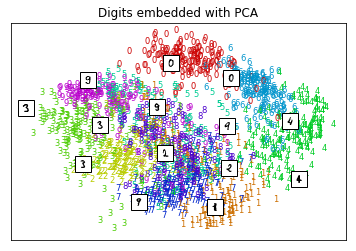

In [6]:
# PCA
pca = PCA(n_components=2)
X_embedp = pca.fit_transform(X)
plot_digits(X_embedp, digits, title='Digits embedded with PCA')

correlation of PCA and linear kPCA: 1.000000
similarity approximation: msqe: 0.7757558402 ; r^2: 0.5362227063 ; rho: 0.7272769661


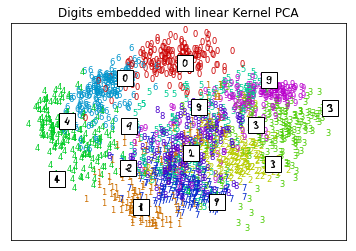

In [7]:
# linear kPCA - same as regular PCA...;)
kpca = KernelPCA(n_components=2, kernel='linear')
X_embed = kpca.fit_transform(X)
plot_digits(X_embed, digits, title='Digits embedded with linear Kernel PCA')
print("correlation of PCA and linear kPCA: %f" % check_embed_match(X_embed, X_embedp)[1])
K_lin = center_K(np.dot(X, X.T))
print("similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_lin))

Epoch 1/15
1797/1797 [==============================] - 0s 154us/step - loss: 2.2556
Epoch 2/15
1797/1797 [==============================] - 0s 101us/step - loss: 1.8459
Epoch 3/15
1797/1797 [==============================] - 0s 93us/step - loss: 1.6266
Epoch 4/15
1797/1797 [==============================] - 0s 85us/step - loss: 1.5647
Epoch 5/15
1797/1797 [==============================] - 0s 87us/step - loss: 1.5053
Epoch 6/15
1797/1797 [==============================] - 0s 87us/step - loss: 1.4515
Epoch 7/15
1797/1797 [==============================] - 0s 96us/step - loss: 1.4114
Epoch 8/15
1797/1797 [==============================] - 0s 98us/step - loss: 1.3867
Epoch 9/15
1797/1797 [==============================] - 0s 100us/step - loss: 1.3722
Epoch 10/15
1797/1797 [==============================] - 0s 93us/step - loss: 1.3616
Epoch 11/15
1797/1797 [==============================] - 0s 91us/step - loss: 1.3512
Epoch 12/15
1797/1797 [==============================] - 0s 88us/step -

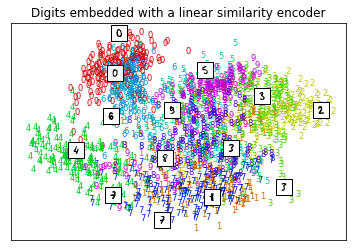

In [8]:
# linear similarity encoder
simec = SimilarityEncoder(X.shape[1], 2, n_targets, l2_reg_emb=0.0001, l2_reg_out=0.0000001, 
                          s_ll_reg=0.5, S_ll=K_lin[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.01))
simec.fit(X, K_lin[:,:n_targets], epochs=15)
X_embeds = simec.transform(X)
plot_digits(X_embeds, digits, title='Digits embedded with a linear similarity encoder')
print("correlation with linear kPCA: %f" % check_embed_match(X_embed, X_embeds)[1])
print("similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_lin))

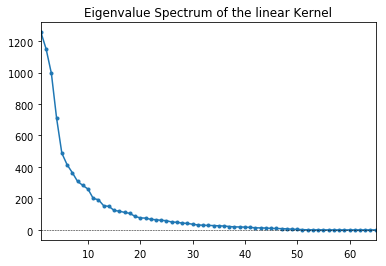

In [9]:
# check how many relevant dimensions there are - obviously at most # feature dim, not # of data points
eigenvals = np.linalg.eigvalsh(K_lin)[::-1]
plt.figure();
plt.plot(list(range(1, K_lin.shape[0]+1)), eigenvals, '-o', markersize=3);
plt.plot([1, K_lin.shape[0]],[0,0], 'k--', linewidth=0.5);
plt.xlim(1, X.shape[1]+1);
plt.title('Eigenvalue Spectrum of the linear Kernel');

2
Epoch 1/25
1797/1797 [==============================] - 0s 171us/step - loss: 2.1801
Epoch 2/25
1797/1797 [==============================] - 0s 84us/step - loss: 1.5766
Epoch 3/25
1797/1797 [==============================] - 0s 86us/step - loss: 1.4730
Epoch 4/25
1797/1797 [==============================] - 0s 94us/step - loss: 1.4115
Epoch 5/25
1797/1797 [==============================] - 0s 87us/step - loss: 1.3472
Epoch 6/25
1797/1797 [==============================] - 0s 85us/step - loss: 1.2927
Epoch 7/25
1797/1797 [==============================] - 0s 93us/step - loss: 1.2575
Epoch 8/25
1797/1797 [==============================] - 0s 91us/step - loss: 1.2399
Epoch 9/25
1797/1797 [==============================] - 0s 86us/step - loss: 1.2327
Epoch 10/25
1797/1797 [==============================] - 0s 87us/step - loss: 1.2303
Epoch 11/25
1797/1797 [==============================] - 0s 91us/step - loss: 1.2293
Epoch 12/25
1797/1797 [==============================] - 0s 92us/step -

1797/1797 [==============================] - 0s 87us/step - loss: 0.0086
Epoch 12/25
1797/1797 [==============================] - 0s 104us/step - loss: 0.0078
Epoch 13/25
1797/1797 [==============================] - 0s 92us/step - loss: 0.0071
Epoch 14/25
1797/1797 [==============================] - 0s 107us/step - loss: 0.0066
Epoch 15/25
1797/1797 [==============================] - 0s 101us/step - loss: 0.0062
Epoch 16/25
1797/1797 [==============================] - 0s 109us/step - loss: 0.0059
Epoch 17/25
1797/1797 [==============================] - 0s 105us/step - loss: 0.0056
Epoch 18/25
1797/1797 [==============================] - 0s 98us/step - loss: 0.0054
Epoch 19/25
1797/1797 [==============================] - 0s 105us/step - loss: 0.0052
Epoch 20/25
1797/1797 [==============================] - 0s 92us/step - loss: 0.0050
Epoch 21/25
1797/1797 [==============================] - 0s 101us/step - loss: 0.0049
Epoch 22/25
1797/1797 [==============================] - 0s 98us/step 

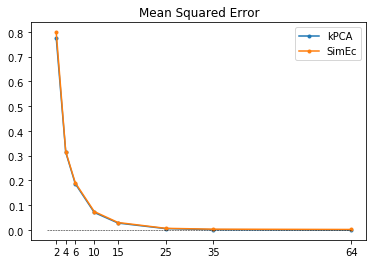

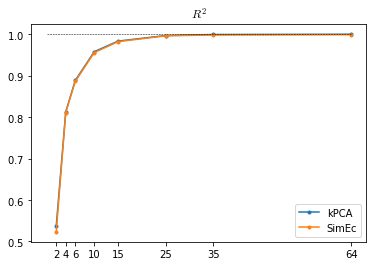

In [10]:
mse_kpca, rsq_kpca = [], []
mse_simec, rsq_simec = [], []
e_dims = [2, 4, 6, 10, 15, 25, 35, X.shape[1]]
for e_dim in e_dims:
    print(e_dim)
    kpca = KernelPCA(n_components=e_dim, kernel='linear')
    X_embed = kpca.fit_transform(X)
    mse_k, rsq, _ = check_similarity_match(X_embed, K_lin)
    mse_kpca.append(mse_k)
    rsq_kpca.append(rsq)
    simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, l2_reg_emb=0.0001, l2_reg_out=0.0000001, 
                              s_ll_reg=0.5, S_ll=K_lin[:n_targets,:n_targets], 
                              opt=keras.optimizers.Adamax(lr=0.01))
    simec.fit(X, K_lin[:,:n_targets])
    X_embeds = simec.transform(X)
    mse, rsq, _ = check_similarity_match(X_embeds, K_lin)
    mse_simec.append(mse)
    rsq_simec.append(rsq)
    print("mse kpca: %f; mse simec: %f" % (mse_k, mse))
    print("correlation with linear kPCA: %f" % check_embed_match(X_embed, X_embeds)[1])
plt.figure();
plt.plot(e_dims, mse_kpca, '-o', markersize=3, label='kPCA');
plt.plot(e_dims, mse_simec, '-o', markersize=3, label='SimEc');
plt.legend(loc=0);
plt.title('Mean Squared Error');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.figure();
plt.plot(e_dims, rsq_kpca, '-o', markersize=3, label='kPCA');
plt.plot(e_dims, rsq_simec, '-o', markersize=3, label='SimEc');
plt.plot([0, e_dims[-1]], [1,1], 'k--', linewidth=0.5);
plt.legend(loc=0);
plt.title('$R^2$');
plt.xticks(e_dims, e_dims);

### Non-linear similarities
Linear kPCA is straight forward, but what if we use a non-linear kernel function like the Gaussian kernel or isomap?
For the corresponding SimEcs we add some non-linear hidden layers.

similarity approximation: msqe: 0.0063632361 ; r^2: 0.5114399447 ; rho: 0.7355431671


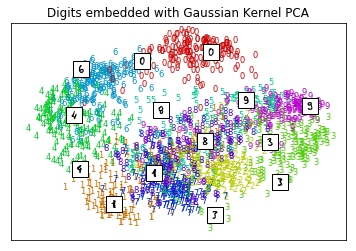

In [11]:
# Gaussian kernel PCA
D = squareform(pdist(X, 'euclidean'))
gamma = 1./(np.median(D)**2)
K_rbf = center_K(rbf_kernel(X, X, gamma))
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
X_embed = kpca.fit_transform(X)
plot_digits(X_embed, digits, title='Digits embedded with Gaussian Kernel PCA')
print("similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_rbf))

Epoch 1/15
1797/1797 [==============================] - 0s 245us/step - loss: 0.0147
Epoch 2/15
1797/1797 [==============================] - 0s 124us/step - loss: 0.0119
Epoch 3/15
1797/1797 [==============================] - 0s 119us/step - loss: 0.0109
Epoch 4/15
1797/1797 [==============================] - 0s 109us/step - loss: 0.0103
Epoch 5/15
1797/1797 [==============================] - 0s 121us/step - loss: 0.0102
Epoch 6/15
1797/1797 [==============================] - 0s 111us/step - loss: 0.0101
Epoch 7/15
1797/1797 [==============================] - 0s 115us/step - loss: 0.0101
Epoch 8/15
1797/1797 [==============================] - 0s 109us/step - loss: 0.0101
Epoch 9/15
1797/1797 [==============================] - 0s 117us/step - loss: 0.0101
Epoch 10/15
1797/1797 [==============================] - 0s 108us/step - loss: 0.0101
Epoch 11/15
1797/1797 [==============================] - 0s 101us/step - loss: 0.0101
Epoch 12/15
1797/1797 [==============================] - 0s 115

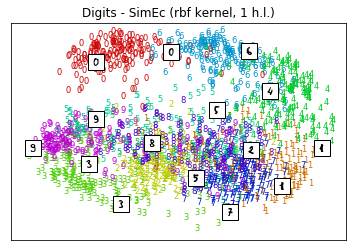

In [12]:
# non-linear SimEc with rbf kernel
simec = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(100, 'tanh')], l2_reg=0.00000001,
                          l2_reg_emb=0.0001, l2_reg_out=0.0000001, s_ll_reg=0.5, S_ll=K_rbf[:n_targets,:n_targets], 
                          opt=keras.optimizers.Adamax(lr=0.01))
simec.fit(X, K_rbf[:,:n_targets], epochs=15)
X_embeds = simec.transform(X)
plot_digits(X_embeds, digits, title='Digits - SimEc (rbf kernel, 1 h.l.)')
print("correlation with Gaussian kPCA: %f" % check_embed_match(X_embed, X_embeds)[1])
print("similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_rbf))

similarity approximation: msqe: 147.6631794001 ; r^2: 0.6349471008 ; rho: 0.7669624925


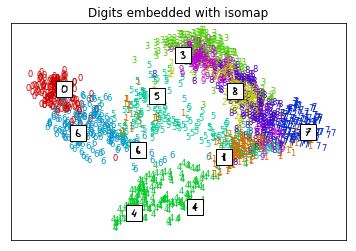

In [13]:
# isomap
isomap = Isomap(n_neighbors=10, n_components=2)
X_embed = isomap.fit_transform(X)
plot_digits(X_embed, digits, title='Digits embedded with isomap')
K_geod = center_K(-0.5*(isomap.dist_matrix_**2))
print("similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_geod))

Epoch 1/25
1797/1797 [==============================] - 0s 241us/step - loss: 4293.0235
Epoch 2/25
1797/1797 [==============================] - 0s 129us/step - loss: 4090.5591
Epoch 3/25
1797/1797 [==============================] - 0s 129us/step - loss: 3986.0831
Epoch 4/25
1797/1797 [==============================] - 0s 123us/step - loss: 3817.0565
Epoch 5/25
1797/1797 [==============================] - 0s 138us/step - loss: 3512.3662
Epoch 6/25
1797/1797 [==============================] - 0s 135us/step - loss: 3079.3507
Epoch 7/25
1797/1797 [==============================] - 0s 140us/step - loss: 2598.3086
Epoch 8/25
1797/1797 [==============================] - 0s 129us/step - loss: 2189.2839
Epoch 9/25
1797/1797 [==============================] - 0s 132us/step - loss: 1925.8843
Epoch 10/25
1797/1797 [==============================] - 0s 126us/step - loss: 1785.2773
Epoch 11/25
1797/1797 [==============================] - 0s 132us/step - loss: 1715.0002
Epoch 12/25
1797/1797 [=======

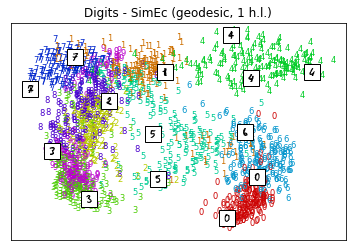

In [14]:
# non-linear SimEc based on isomap
simec = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(100, 'tanh')], s_ll_reg=10., 
                          S_ll=K_geod[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.01))
simec.fit(X, K_geod[:,:n_targets])
X_embeds = simec.transform(X)
plot_digits(X_embeds, digits, title='Digits - SimEc (geodesic, 1 h.l.)')
print("correlation with isomap: %f" % check_embed_match(X_embed, X_embeds)[1])
print("similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_geod))

Epoch 1/25
1797/1797 [==============================] - 0s 274us/step - loss: 4277.5565
Epoch 2/25
1797/1797 [==============================] - 0s 136us/step - loss: 4168.8094
Epoch 3/25
1797/1797 [==============================] - 0s 139us/step - loss: 4073.6531
Epoch 4/25
1797/1797 [==============================] - 0s 138us/step - loss: 3962.5300
Epoch 5/25
1797/1797 [==============================] - 0s 137us/step - loss: 3786.0767
Epoch 6/25
1797/1797 [==============================] - 0s 136us/step - loss: 3510.4661
Epoch 7/25
1797/1797 [==============================] - 0s 134us/step - loss: 3150.8524
Epoch 8/25
1797/1797 [==============================] - 0s 140us/step - loss: 2758.5493
Epoch 9/25
1797/1797 [==============================] - 0s 131us/step - loss: 2398.2024
Epoch 10/25
1797/1797 [==============================] - 0s 140us/step - loss: 2103.3338
Epoch 11/25
1797/1797 [==============================] - 0s 143us/step - loss: 1889.1052
Epoch 12/25
1797/1797 [=======

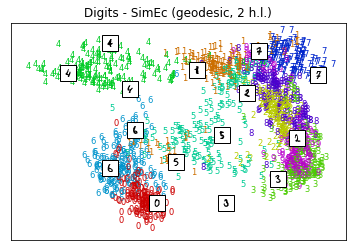

In [15]:
# non-linear SimEc based on isomap - 2 hidden layers
simec = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(200, 'tanh'), (100, 'tanh')],
                          s_ll_reg=10., S_ll=K_geod[:n_targets,:n_targets], 
                          opt=keras.optimizers.Adamax(lr=0.01))
simec.fit(X, K_geod[:,:n_targets])
X_embeds = simec.transform(X)
plot_digits(X_embeds, digits, title='Digits - SimEc (geodesic, 2 h.l.)')
print("correlation with isomap: %f" % check_embed_match(X_embed, X_embeds)[1])
print("similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_geod))

## MNIST Dataset
Embedding the regular 28x28 pixel MNIST digits

In [16]:
# load digits
mnist = fetch_mldata('MNIST original', data_home='data')
X = mnist.data/255.  # normalize to 0-1
y = np.array(mnist.target, dtype=int)
# subsample 10000 random data points
np.random.seed(42)
n_samples = 10000
n_test = 2000
n_targets = 1000
rnd_idx = np.random.permutation(X.shape[0])[:n_samples]
X_test, y_test = X[rnd_idx[:n_test],:], y[rnd_idx[:n_test]]
X, y = X[rnd_idx[n_test:],:], y[rnd_idx[n_test:]]
ss = StandardScaler(with_std=False)
X = ss.fit_transform(X)
X_test = ss.transform(X_test)
n_train, n_features = X.shape
keras.backend.clear_session()

### Linear Similarity
Linear SimEc again gives the same solution as PCA/linear kPCA.

similarity approximation       : msqe: 51.4531662441 ; r^2: 0.4438507851 ; rho: 0.6341602248
similarity approximation (test): msqe: 50.7905947898 ; r^2: 0.4383615137 ; rho: 0.6283114626


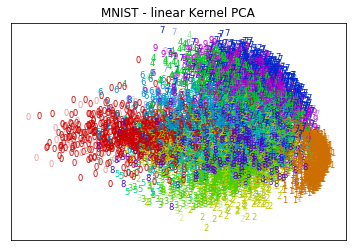

In [17]:
# linear kPCA
K_lin = center_K(np.dot(X, X.T))
K_lin_test = center_K(np.dot(X_test, X_test.T))
kpca = KernelPCA(n_components=2, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - linear Kernel PCA')
if savefigs: plt.savefig('fig_spectral_mnist_lin_kpca.png', dpi=300)
print("similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_lin))
print("similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_test, K_lin_test))

Epoch 1/25
8000/8000 [==============================] - 1s 108us/step - loss: 117.3314
Epoch 2/25
8000/8000 [==============================] - 1s 95us/step - loss: 99.1230
Epoch 3/25
8000/8000 [==============================] - 1s 95us/step - loss: 98.2795
Epoch 4/25
8000/8000 [==============================] - 1s 92us/step - loss: 97.9529
Epoch 5/25
8000/8000 [==============================] - 1s 90us/step - loss: 97.6107
Epoch 6/25
8000/8000 [==============================] - 1s 94us/step - loss: 97.1363
Epoch 7/25
8000/8000 [==============================] - 1s 95us/step - loss: 96.4552
Epoch 8/25
8000/8000 [==============================] - 1s 93us/step - loss: 95.4403
Epoch 9/25
8000/8000 [==============================] - 1s 92us/step - loss: 93.9135
Epoch 10/25
8000/8000 [==============================] - 1s 92us/step - loss: 91.7323
Epoch 11/25
8000/8000 [==============================] - 1s 92us/step - loss: 88.9059
Epoch 12/25
8000/8000 [==============================] - 1s 9

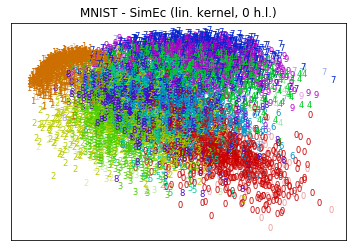

In [18]:
# linear similarity encoder
simec = SimilarityEncoder(X.shape[1], 2, n_targets, l2_reg_emb=0.001, l2_reg_out=0.00001, 
                          s_ll_reg=0.5, S_ll=K_lin[:n_targets,:n_targets], 
                          opt=keras.optimizers.Adamax(lr=0.005))
simec.fit(X, K_lin[:,:n_targets])
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot_mnist(X_embeds, y, X_embed_tests, y_test, title='MNIST - SimEc (lin. kernel, 0 h.l.)')
if savefigs: plt.savefig('fig_spectral_mnist_lin_simec.png', dpi=300)
print("correlation with lin kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1])
print("correlation with lin kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1])
print("similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_lin))
print("similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_tests, K_lin_test))

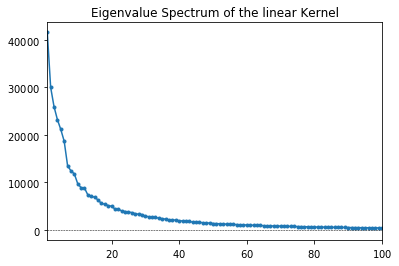

In [19]:
# check how many relevant dimensions there are - obviously at most # feature dim, not # of data points
eigenvals = np.linalg.eigvalsh(K_lin)[::-1]
plt.figure();
plt.plot(list(range(1, K_lin.shape[0]+1)), eigenvals, '-o', markersize=3);
plt.plot([1, K_lin.shape[0]],[0,0], 'k--', linewidth=0.5);
plt.xlim(1, 100);
plt.title('Eigenvalue Spectrum of the linear Kernel');

2
Epoch 1/25
8000/8000 [==============================] - 1s 105us/step - loss: 125.8069
Epoch 2/25
8000/8000 [==============================] - 1s 90us/step - loss: 105.9089
Epoch 3/25
8000/8000 [==============================] - 1s 91us/step - loss: 100.9113
Epoch 4/25
8000/8000 [==============================] - 1s 90us/step - loss: 99.8149
Epoch 5/25
8000/8000 [==============================] - 1s 89us/step - loss: 99.1342
Epoch 6/25
8000/8000 [==============================] - 1s 94us/step - loss: 98.6052
Epoch 7/25
8000/8000 [==============================] - 1s 92us/step - loss: 98.1797
Epoch 8/25
8000/8000 [==============================] - 1s 91us/step - loss: 97.8252
Epoch 9/25
8000/8000 [==============================] - 1s 89us/step - loss: 97.4848
Epoch 10/25
8000/8000 [==============================] - 1s 93us/step - loss: 97.1184
Epoch 11/25
8000/8000 [==============================] - 1s 94us/step - loss: 96.6854
Epoch 12/25
8000/8000 [==============================] - 

/home/franzi/anaconda2/lib/python2.7/site-packages/sklearn/random_projection.py:378: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (784 < 1000).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


Epoch 1/25
8000/8000 [==============================] - 1s 130us/step - loss: 74.0261
Epoch 2/25
8000/8000 [==============================] - 1s 100us/step - loss: 50.3449
Epoch 3/25
8000/8000 [==============================] - 1s 100us/step - loss: 42.8453
Epoch 4/25
8000/8000 [==============================] - 1s 103us/step - loss: 31.5501
Epoch 5/25
8000/8000 [==============================] - 1s 100us/step - loss: 18.7264
Epoch 6/25
8000/8000 [==============================] - 1s 97us/step - loss: 10.8143
Epoch 7/25
8000/8000 [==============================] - 1s 100us/step - loss: 6.4521
Epoch 8/25
8000/8000 [==============================] - 1s 98us/step - loss: 4.1013
Epoch 9/25
8000/8000 [==============================] - 1s 95us/step - loss: 2.8298
Epoch 10/25
8000/8000 [==============================] - 1s 101us/step - loss: 2.0606
Epoch 11/25
8000/8000 [==============================] - 1s 101us/step - loss: 1.6248
Epoch 12/25
8000/8000 [==============================] - 1s 

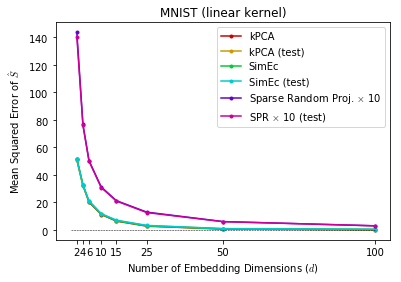

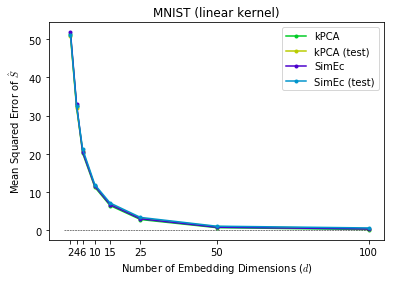

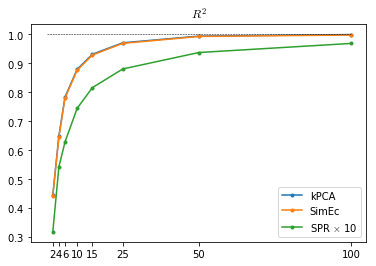

In [20]:
mse_rp, mse_rp_test, rsq_rp = [], [], []
mse_kpca, mse_kpca_test, rsq_kpca = [], [], []
mse_simec, mse_simec_test, rsq_simec = [], [], []
e_dims = [2, 4, 6, 10, 15, 25, 50, 100]
for e_dim in e_dims:
    print(e_dim)
    # random projections
    rp = SparseRandomProjection(n_components=10*e_dim, random_state=42)
    X_embed = rp.fit_transform(X)
    X_embed_test = rp.transform(X_test)
    mse_r, rsq, _ = check_similarity_match(X_embed, K_lin)
    mse_rp.append(mse_r)
    rsq_rp.append(rsq)
    mse_rt, _, _ = check_similarity_match(X_embed_test, K_lin_test)
    mse_rp_test.append(mse_rt)
    # kpca
    kpca = KernelPCA(n_components=e_dim, kernel='linear')
    X_embed = kpca.fit_transform(X)
    X_embed_test = kpca.transform(X_test)
    mse_k, rsq, _ = check_similarity_match(X_embed, K_lin)
    mse_kpca.append(mse_k)
    rsq_kpca.append(rsq)
    mse_kt, _, _ = check_similarity_match(X_embed_test, K_lin_test)
    mse_kpca_test.append(mse_kt)
    # simec
    l = 0.002 if e_dim == 100 else 0.001
    simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, s_ll_reg=0.5, S_ll=K_lin[:n_targets,:n_targets],
                              l2_reg_emb=l, l2_reg_out=0.00001, opt=keras.optimizers.Adamax(lr=0.003))
    simec.fit(X, K_lin[:,:n_targets])
    X_embeds = simec.transform(X)
    X_embed_tests = simec.transform(X_test)
    mse, rsq, _ = check_similarity_match(X_embeds, K_lin)
    mse_simec.append(mse)
    rsq_simec.append(rsq)
    mse_t, _, _ = check_similarity_match(X_embed_tests, K_lin_test)
    mse_simec_test.append(mse_t)
    print("mse rp: %f (%f); mse kpca: %f (%f); mse simec: %f (%f)" % (mse_r, mse_rt, mse_k, mse_kt, mse, mse_t))
    print("correlation with linear kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1])
    print("correlation with linear kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1])
keras.backend.clear_session()
colors = get_colors(15)
plt.figure();
plt.plot(e_dims, mse_kpca, '-o', markersize=3, c=colors[0], label='kPCA');
plt.plot(e_dims, mse_kpca_test, '-o', markersize=3, c=colors[2], label='kPCA (test)');
plt.plot(e_dims, mse_simec, '-o', markersize=3, c=colors[6], label='SimEc');
plt.plot(e_dims, mse_simec_test, '-o', markersize=3, c=colors[8], label='SimEc (test)');
plt.plot(e_dims, mse_rp, '-o', markersize=3, c=colors[12], label='Sparse Random Proj. $\\times$ 10');
plt.plot(e_dims, mse_rp_test, '-o', markersize=3, c=colors[14], label='SPR $\\times$ 10 (test)');
plt.legend(loc=0);
plt.title('MNIST (linear kernel)');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions ($d$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
plt.figure();
colors = get_colors(10)
plt.plot(e_dims, mse_kpca, '-o', markersize=3, c=colors[4], label='kPCA');
plt.plot(e_dims, mse_kpca_test, '-o', markersize=3, c=colors[2], label='kPCA (test)');
plt.plot(e_dims, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(e_dims, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.title('MNIST (linear kernel)');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions ($d$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
#plt.ylabel(r'$\frac{1}{N^2} \sum ( S-\hat{S} )^2$')
print("e_dims=", e_dims)
print("mse_kpca=", mse_kpca)
print("mse_kpca_test=", mse_kpca_test)
print("mse_simec=", mse_simec)
print("mse_simec_test=", mse_simec_test)
if savefigs: plt.savefig('fig_spectral_mnist_lin_mse_edim.pdf', dpi=300)
plt.figure();
plt.plot(e_dims, rsq_kpca, '-o', markersize=3, label='kPCA');
plt.plot(e_dims, rsq_simec, '-o', markersize=3, label='SimEc');
plt.plot(e_dims, rsq_rp, '-o', markersize=3, label='SPR $\\times$ 10');
plt.plot([0, e_dims[-1]], [1,1], 'k--', linewidth=0.5);
plt.legend(loc=0);
plt.title('$R^2$');
plt.xticks(e_dims, e_dims);

100
Epoch 1/25
8000/8000 [==============================] - 1s 93us/step - loss: 116.3805
Epoch 2/25
8000/8000 [==============================] - 1s 83us/step - loss: 81.2289
Epoch 3/25
8000/8000 [==============================] - 1s 83us/step - loss: 74.5045
Epoch 4/25
8000/8000 [==============================] - 1s 86us/step - loss: 70.6748
Epoch 5/25
8000/8000 [==============================] - 1s 86us/step - loss: 67.7915
Epoch 6/25
8000/8000 [==============================] - 1s 90us/step - loss: 64.3912
Epoch 7/25
8000/8000 [==============================] - 1s 87us/step - loss: 59.4398
Epoch 8/25
8000/8000 [==============================] - 1s 86us/step - loss: 52.6649
Epoch 9/25
8000/8000 [==============================] - 1s 89us/step - loss: 44.8417
Epoch 10/25
8000/8000 [==============================] - 1s 84us/step - loss: 37.2295
Epoch 11/25
8000/8000 [==============================] - 1s 86us/step - loss: 30.7684
Epoch 12/25
8000/8000 [==============================] - 1

8000/8000 [==============================] - 1s 89us/step - loss: 18.0083
Epoch 20/25
8000/8000 [==============================] - 1s 86us/step - loss: 17.6050
Epoch 21/25
8000/8000 [==============================] - 1s 85us/step - loss: 17.3345
Epoch 22/25
8000/8000 [==============================] - 1s 92us/step - loss: 17.1773
Epoch 23/25
8000/8000 [==============================] - 1s 94us/step - loss: 17.0985
Epoch 24/25
8000/8000 [==============================] - 1s 92us/step - loss: 17.0612
Epoch 25/25
8000/8000 [==============================] - 1s 95us/step - loss: 17.0461
mse kpca: 11.208740 (11.554723); mse simec: 11.568571 (11.924045)
1000
Epoch 1/25
8000/8000 [==============================] - 1s 121us/step - loss: 105.6294
Epoch 2/25
8000/8000 [==============================] - 1s 95us/step - loss: 73.1678
Epoch 3/25
8000/8000 [==============================] - 1s 96us/step - loss: 63.3200
Epoch 4/25
8000/8000 [==============================] - 1s 96us/step - loss: 59.47

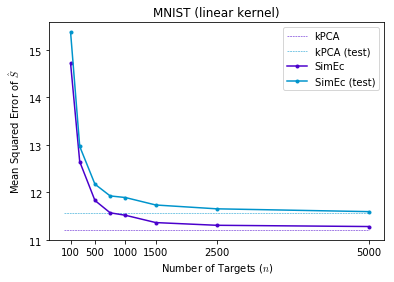

In [21]:
# check effect of different number of targets
mse_simec, mse_simec_test = [], []
targets = [100, 250, 500, 750, 1000, 1500, 2500, 5000]
kpca = KernelPCA(n_components=10, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
mse_k = check_similarity_match(X_embed, K_lin)[0]
mse_kt = check_similarity_match(X_embed_test, K_lin_test)[0]
for n in targets:
    print(n)
    simec = SimilarityEncoder(X.shape[1], 10, n, s_ll_reg=0.5, S_ll=K_lin[:n,:n], l2_reg_emb=0.001, 
                              l2_reg_out=0.00001, opt=keras.optimizers.Adamax(lr=0.003))
    simec.fit(X, K_lin[:,:n])
    X_embed = simec.transform(X)
    X_embed_test = simec.transform(X_test)
    mse = check_similarity_match(X_embed, K_lin)[0]
    mse_simec.append(mse)
    mse_t = check_similarity_match(X_embed_test, K_lin_test)[0]
    mse_simec_test.append(mse_t)
    print("mse kpca: %f (%f); mse simec: %f (%f)" % (mse_k, mse_kt, mse, mse_t))
keras.backend.clear_session()
colors = get_colors(10)
plt.figure();
plt.plot([0, targets[-1]], [mse_k, mse_k], '--', linewidth=0.5, c=colors[8], label='kPCA');
plt.plot([0, targets[-1]], [mse_kt, mse_kt], '--', linewidth=0.5, c=colors[6], label='kPCA (test)');
plt.plot(targets, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(targets, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.title('MNIST (linear kernel)');
plt.xticks([100, 500, 1000, 1500, 2500, 5000], [100, 500, 1000, 1500, 2500, 5000]);
plt.xlabel('Number of Targets ($n$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print("targets=", targets)
print("mse_k=", mse_k)
print("mse_kt=", mse_kt)
print("mse_simec=", mse_simec)
print("mse_simec_test=", mse_simec_test)
if savefigs: plt.savefig('fig_spectral_mnist_lin_mse_ntargets.pdf', dpi=300)

0.0
Epoch 1/25
8000/8000 [==============================] - 1s 151us/step - loss: 105.2221
Epoch 2/25
8000/8000 [==============================] - 1s 104us/step - loss: 70.9171
Epoch 3/25
8000/8000 [==============================] - 1s 108us/step - loss: 64.4375
Epoch 4/25
8000/8000 [==============================] - 1s 102us/step - loss: 59.1070
Epoch 5/25
8000/8000 [==============================] - 1s 105us/step - loss: 55.7027
Epoch 6/25
8000/8000 [==============================] - 1s 101us/step - loss: 52.9292
Epoch 7/25
8000/8000 [==============================] - 1s 101us/step - loss: 49.1944
Epoch 8/25
8000/8000 [==============================] - 1s 104us/step - loss: 44.0094
Epoch 9/25
8000/8000 [==============================] - 1s 103us/step - loss: 37.8490
Epoch 10/25
8000/8000 [==============================] - 1s 105us/step - loss: 31.9982
Epoch 11/25
8000/8000 [==============================] - 1s 99us/step - loss: 27.2606
Epoch 12/25
8000/8000 [=========================

8000/8000 [==============================] - 1s 103us/step - loss: 55.5200
Epoch 10/25
8000/8000 [==============================] - 1s 108us/step - loss: 53.9854
Epoch 11/25
8000/8000 [==============================] - 1s 108us/step - loss: 52.1568
Epoch 12/25
8000/8000 [==============================] - 1s 108us/step - loss: 49.9198
Epoch 13/25
8000/8000 [==============================] - 1s 103us/step - loss: 47.1933
Epoch 14/25
8000/8000 [==============================] - 1s 103us/step - loss: 43.9897
Epoch 15/25
8000/8000 [==============================] - 1s 104us/step - loss: 40.4695
Epoch 16/25
8000/8000 [==============================] - 1s 101us/step - loss: 36.8989
Epoch 17/25
8000/8000 [==============================] - 1s 103us/step - loss: 33.5506
Epoch 18/25
8000/8000 [==============================] - 1s 105us/step - loss: 30.5892
Epoch 19/25
8000/8000 [==============================] - 1s 104us/step - loss: 28.0511
Epoch 20/25
8000/8000 [==============================] 

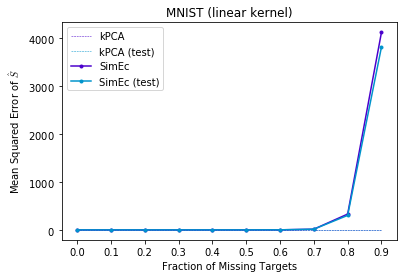

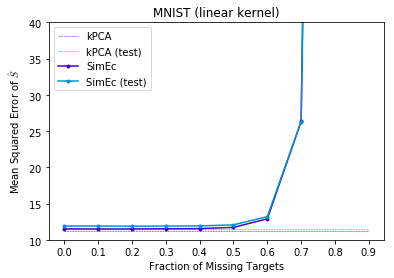

In [22]:
# missing targets
n_targets = 1000
np.random.seed(15)
mse_simec, mse_simec_test = [], []
kpca = KernelPCA(n_components=10, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
mse_k = check_similarity_match(X_embed, K_lin)[0]
mse_kt = check_similarity_match(X_embed_test, K_lin_test)[0]
missing_targets = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for m in missing_targets:
    print(m)
    K_lin_noisy = K_lin.copy()
    K_lin_noisy[np.random.rand(*K_lin_noisy.shape)<=m] = -100
    simec = SimilarityEncoder(X.shape[1], 10, n_targets, mask_value=-100, s_ll_reg=0.5, 
                              S_ll=K_lin_noisy[:n_targets,:n_targets], l2_reg_emb=0.01, 
                              l2_reg_out=0.00001, opt=keras.optimizers.Adamax(lr=0.003))
    simec.fit(X, K_lin_noisy[:,:n_targets])
    X_embed = simec.transform(X)
    X_embed_test = simec.transform(X_test)
    mse = check_similarity_match(X_embed, K_lin)[0]
    mse_simec.append(mse)
    mse_t = check_similarity_match(X_embed_test, K_lin_test)[0]
    mse_simec_test.append(mse_t)
    print("mse kpca: %f (%f); mse simec: %f (%f)" % (mse_k, mse_kt, mse, mse_t))
keras.backend.clear_session()
colors = get_colors(10)
plt.figure();
plt.plot([0, missing_targets[-1]], [mse_k, mse_k], '--', linewidth=0.5, c=colors[8], label='kPCA');
plt.plot([0, missing_targets[-1]], [mse_kt, mse_kt], '--', linewidth=0.5, c=colors[6], label='kPCA (test)');
plt.plot(missing_targets, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(missing_targets, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.title('MNIST (linear kernel)');
plt.xticks(missing_targets, missing_targets);
plt.xlabel('Fraction of Missing Targets')
plt.ylabel('Mean Squared Error of $\hat{S}$')
plt.figure();
plt.plot([0, missing_targets[-1]], [mse_k, mse_k], '--', linewidth=0.5, c=colors[8], label='kPCA');
plt.plot([0, missing_targets[-1]], [mse_kt, mse_kt], '--', linewidth=0.5, c=colors[6], label='kPCA (test)');
plt.plot(missing_targets, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(missing_targets, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.ylim([10, 40])
plt.title('MNIST (linear kernel)');
plt.xticks(missing_targets, missing_targets);
plt.xlabel('Fraction of Missing Targets')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print("missing_targets=", missing_targets)
print("mse_k=", mse_k)
print("mse_kt=", mse_kt)
print("mse_simec=", mse_simec)
print("mse_simec_test=", mse_simec_test)
if savefigs: plt.savefig('fig_spectral_mnist_lin_mse_missingt.pdf', dpi=300)

### Non-linear Similarities
Isomap and corresponding SimEc with 2 hidden layers.

similarity approximation: msqe: 19389.7075635951 ; r^2: 0.4654955215 ; rho: 0.6520907770


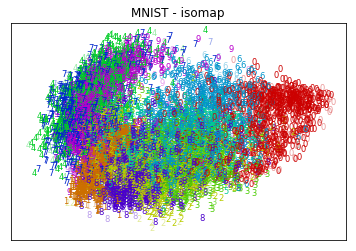

In [23]:
# isomap
n_targets = 1000
isomap = Isomap(n_neighbors=10, n_components=2)
X_embed = isomap.fit_transform(X)
X_embed_test = isomap.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - isomap')
K_geod = center_K(-0.5*(isomap.dist_matrix_**2))
print("similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_geod))

Epoch 1/25
8000/8000 [==============================] - 2s 193us/step - loss: 387395.0545
Epoch 2/25
8000/8000 [==============================] - 1s 169us/step - loss: 381733.2685
Epoch 3/25
8000/8000 [==============================] - 1s 168us/step - loss: 378625.1790
Epoch 4/25
8000/8000 [==============================] - 1s 168us/step - loss: 372833.8725
Epoch 5/25
8000/8000 [==============================] - 1s 168us/step - loss: 366694.2677
Epoch 6/25
8000/8000 [==============================] - 1s 169us/step - loss: 359559.5355
Epoch 7/25
8000/8000 [==============================] - 1s 167us/step - loss: 349702.0372
Epoch 8/25
8000/8000 [==============================] - 1s 166us/step - loss: 336639.4718
Epoch 9/25
8000/8000 [==============================] - 1s 167us/step - loss: 321316.4741
Epoch 10/25
8000/8000 [==============================] - 1s 165us/step - loss: 305084.1437
Epoch 11/25
8000/8000 [==============================] - 1s 165us/step - loss: 289244.2549
Epoch 12

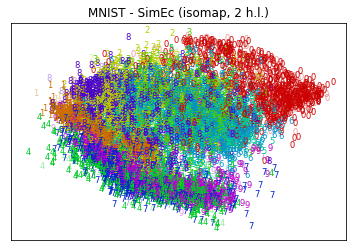

In [24]:
# non-linear SimEc to approximate isomap solution
simec = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(200, 'tanh'), (100, 'tanh')], l2_reg=0.0005, 
                          l2_reg_emb=0.001, l2_reg_out=0.000001, s_ll_reg=10., S_ll=K_geod[:n_targets,:n_targets],
                          opt=keras.optimizers.Adamax(lr=0.005))
simec.fit(X, K_geod[:,:n_targets])
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot_mnist(X_embeds, y, X_embed_tests, y_test, title='MNIST - SimEc (isomap, 2 h.l.)')
print("correlation with isomap: %f" % check_embed_match(X_embed, X_embeds)[1])
print("correlation with isomap (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1])
print("similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_geod))

gamma: 0.00475
similarity approximation       : msqe: 0.0017745004 ; r^2: 0.4544257374 ; rho: 0.6513194244
similarity approximation (test): msqe: 0.0017821277 ; r^2: 0.4476707996 ; rho: 0.6471248815


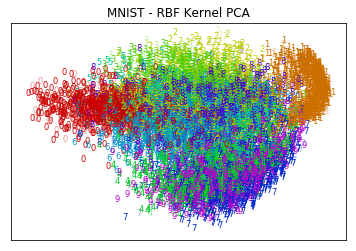

In [25]:
# Gaussian kernel PCA
D = squareform(pdist(X, 'euclidean'))
sigma = np.median(D)
gamma = 0.5/(sigma**2)
print("gamma: %.5f" % gamma)
K_rbf_nonc = rbf_kernel(X, X, gamma)
K_rbf = center_K(K_rbf_nonc)
K_rbf_test_nonc = rbf_kernel(X_test, X_test, gamma)
K_rbf_test = center_K(K_rbf_test_nonc)
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - RBF Kernel PCA')
if savefigs: plt.savefig('fig_spectral_mnist_rbf_kpca.png', dpi=300)
print("similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_rbf))
print("similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_test, K_rbf_test))

Epoch 1/25
8000/8000 [==============================] - 1s 157us/step - loss: 0.0053
Epoch 2/25
8000/8000 [==============================] - 1s 89us/step - loss: 0.0044
Epoch 3/25
8000/8000 [==============================] - 1s 90us/step - loss: 0.0038
Epoch 4/25
8000/8000 [==============================] - 1s 90us/step - loss: 0.0036
Epoch 5/25
8000/8000 [==============================] - 1s 90us/step - loss: 0.0035
Epoch 6/25
8000/8000 [==============================] - 1s 86us/step - loss: 0.0034
Epoch 7/25
8000/8000 [==============================] - 1s 89us/step - loss: 0.0033
Epoch 8/25
8000/8000 [==============================] - 1s 86us/step - loss: 0.0033
Epoch 9/25
8000/8000 [==============================] - 1s 88us/step - loss: 0.0032
Epoch 10/25
8000/8000 [==============================] - 1s 91us/step - loss: 0.0031
Epoch 11/25
8000/8000 [==============================] - 1s 94us/step - loss: 0.0030
Epoch 12/25
8000/8000 [==============================] - 1s 85us/step - l

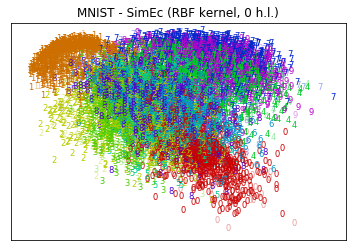

In [26]:
# linear SimEc with rbf kernel
simec = SimilarityEncoder(X.shape[1], 2, n_targets, l2_reg_emb=0.0001, l2_reg_out=0.0000001, 
                          s_ll_reg=0.5, S_ll=K_rbf[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.0003))
simec.fit(X, K_rbf[:,:n_targets], epochs=25)
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot_mnist(X_embeds, y, X_embed_tests, y_test, title='MNIST - SimEc (RBF kernel, 0 h.l.)')
print("correlation with kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1])
print("correlation with kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1])
print("similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_rbf))
print("similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_tests, K_rbf_test))

Epoch 1/25
8000/8000 [==============================] - 1s 146us/step - loss: 0.0200
Epoch 2/25
8000/8000 [==============================] - 1s 122us/step - loss: 0.0183
Epoch 3/25
8000/8000 [==============================] - 1s 122us/step - loss: 0.0158
Epoch 4/25
8000/8000 [==============================] - 1s 120us/step - loss: 0.0134
Epoch 5/25
8000/8000 [==============================] - 1s 121us/step - loss: 0.0120
Epoch 6/25
8000/8000 [==============================] - 1s 123us/step - loss: 0.0115
Epoch 7/25
8000/8000 [==============================] - 1s 121us/step - loss: 0.0114
Epoch 8/25
8000/8000 [==============================] - 1s 113us/step - loss: 0.0114
Epoch 9/25
8000/8000 [==============================] - 1s 114us/step - loss: 0.0113
Epoch 10/25
8000/8000 [==============================] - 1s 120us/step - loss: 0.0113
Epoch 11/25
8000/8000 [==============================] - 1s 123us/step - loss: 0.0113
Epoch 12/25
8000/8000 [==============================] - 1s 122

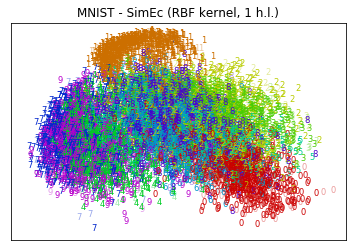

In [27]:
# non-linear SimEc with rbf kernel
simec = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(1000, 'tanh')], l2_reg=0.00000001, 
                          l2_reg_emb=0.00001, l2_reg_out=0.0000001, s_ll_reg=5., 
                          S_ll=K_rbf[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.0003))
simec.fit(X, K_rbf[:,:n_targets], epochs=25)
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot_mnist(X_embeds, y, X_embed_tests, y_test, title='MNIST - SimEc (RBF kernel, 1 h.l.)')
if savefigs: plt.savefig('fig_spectral_mnist_rbf_simec.png', dpi=300)
print("correlation with kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1])
print("correlation with kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1])
print("similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_rbf))
print("similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_tests, K_rbf_test))

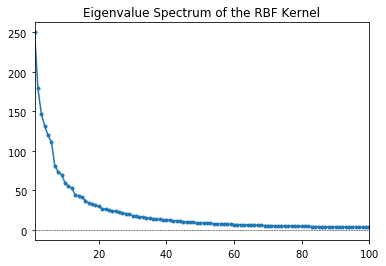

In [28]:
# check how many relevant dimensions there are - obviously at most # feature dim, not # of data points
eigenvals = np.linalg.eigvalsh(K_rbf)[::-1]
plt.figure();
plt.plot(list(range(1, K_rbf.shape[0]+1)), eigenvals, '-o', markersize=3);
plt.plot([1, K_rbf.shape[0]],[0,0], 'k--', linewidth=0.5);
plt.xlim(1, 100);
plt.title('Eigenvalue Spectrum of the RBF Kernel');

2
Epoch 1/25
8000/8000 [==============================] - 1s 152us/step - loss: 0.0194
Epoch 2/25
8000/8000 [==============================] - 1s 121us/step - loss: 0.0159
Epoch 3/25
8000/8000 [==============================] - 1s 126us/step - loss: 0.0129
Epoch 4/25
8000/8000 [==============================] - 1s 122us/step - loss: 0.0120
Epoch 5/25
8000/8000 [==============================] - 1s 121us/step - loss: 0.0117
Epoch 6/25
8000/8000 [==============================] - 1s 122us/step - loss: 0.0115
Epoch 7/25
8000/8000 [==============================] - 1s 119us/step - loss: 0.0114
Epoch 8/25
8000/8000 [==============================] - 1s 121us/step - loss: 0.0114
Epoch 9/25
8000/8000 [==============================] - 1s 123us/step - loss: 0.0114
Epoch 10/25
8000/8000 [==============================] - 1s 120us/step - loss: 0.0114
Epoch 11/25
8000/8000 [==============================] - 1s 123us/step - loss: 0.0114
Epoch 12/25
8000/8000 [==============================] - 1s 1

8000/8000 [==============================] - 1s 175us/step - loss: 0.0184
Epoch 2/25
8000/8000 [==============================] - 1s 128us/step - loss: 0.0063
Epoch 3/25
8000/8000 [==============================] - 1s 130us/step - loss: 0.0036
Epoch 4/25
8000/8000 [==============================] - 1s 128us/step - loss: 0.0025
Epoch 5/25
8000/8000 [==============================] - 1s 127us/step - loss: 0.0020
Epoch 6/25
8000/8000 [==============================] - 1s 129us/step - loss: 0.0016
Epoch 7/25
8000/8000 [==============================] - 1s 130us/step - loss: 0.0013
Epoch 8/25
8000/8000 [==============================] - 1s 126us/step - loss: 0.0011
Epoch 9/25
8000/8000 [==============================] - 1s 132us/step - loss: 9.0128e-04
Epoch 10/25
8000/8000 [==============================] - 1s 129us/step - loss: 7.5898e-04
Epoch 11/25
8000/8000 [==============================] - 1s 127us/step - loss: 6.3259e-04
Epoch 12/25
8000/8000 [==============================] - 1s 12

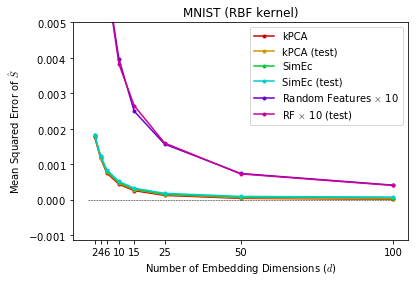

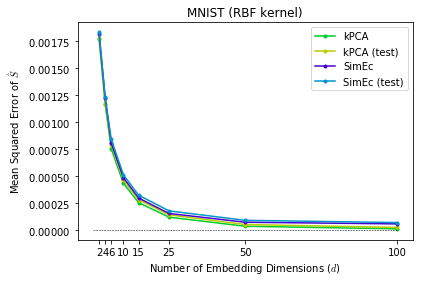

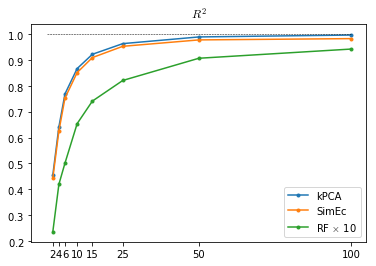

In [29]:
mse_rf, mse_rf_test, rsq_rf = [], [], []
mse_kpca, mse_kpca_test, rsq_kpca = [], [], []
mse_simec, mse_simec_test, rsq_simec = [], [], []
e_dims = [2, 4, 6, 10, 15, 25, 50, 100]
for e_dim in e_dims:
    print(e_dim)
    # random features
    W = np.random.normal(size=(5*e_dim, X.shape[1]), scale=1./sigma)
    tmp = X.dot(W.T)
    X_embed = np.sqrt(1./(5*e_dim)) * np.hstack([np.cos(tmp), np.sin(tmp)])
    tmp = X_test.dot(W.T)
    X_embed_test = np.sqrt(1./(5*e_dim)) * np.hstack([np.cos(tmp), np.sin(tmp)])
    mse_r, rsq, _ = check_similarity_match(X_embed, K_rbf_nonc)
    mse_rf.append(mse_r)
    rsq_rf.append(rsq)
    mse_rt, _, _ = check_similarity_match(X_embed_test, K_rbf_test_nonc)
    mse_rf_test.append(mse_rt)
    # kernel pca
    kpca = KernelPCA(n_components=e_dim, kernel='rbf', gamma=gamma)
    X_embed = kpca.fit_transform(X)
    X_embed_test = kpca.transform(X_test)
    mse_k, rsq, _ = check_similarity_match(X_embed, K_rbf)
    mse_kpca.append(mse_k)
    rsq_kpca.append(rsq)
    mse_kt, _, _ = check_similarity_match(X_embed_test, K_rbf_test)
    mse_kpca_test.append(mse_kt)
    # simec
    simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, hidden_layers=[(1000, 'tanh')], 
                              l2_reg=0.00000001, l2_reg_emb=0.00001, l2_reg_out=0.0000001, 
                              s_ll_reg=5., S_ll=K_rbf[:n_targets,:n_targets], 
                              opt=keras.optimizers.Adamax(lr=0.0005))
    simec.fit(X, K_rbf[:,:n_targets])
    X_embeds = simec.transform(X)
    X_embed_tests = simec.transform(X_test)
    mse, rsq, _ = check_similarity_match(X_embeds, K_rbf)
    mse_simec.append(mse)
    rsq_simec.append(rsq)
    mse_t, _, _ = check_similarity_match(X_embed_tests, K_rbf_test)
    mse_simec_test.append(mse_t)
    print("mse rf: %f (%f); mse kpca: %f (%f); mse simec: %f (%f)" % (mse_r, mse_rt, mse_k, mse_kt, mse, mse_t))
    print("correlation with kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1])
    print("correlation with kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1])
keras.backend.clear_session()
colors = get_colors(15)
plt.figure();
plt.plot(e_dims, mse_kpca, '-o', markersize=3, c=colors[0], label='kPCA');
plt.plot(e_dims, mse_kpca_test, '-o', markersize=3, c=colors[2], label='kPCA (test)');
plt.plot(e_dims, mse_simec, '-o', markersize=3, c=colors[6], label='SimEc');
plt.plot(e_dims, mse_simec_test, '-o', markersize=3, c=colors[8], label='SimEc (test)');
plt.plot(e_dims, mse_rf, '-o', markersize=3, c=colors[12], label='Random Features $\\times$ 10');
plt.plot(e_dims, mse_rf_test, '-o', markersize=3, c=colors[14], label='RF $\\times$ 10 (test)');
plt.legend(loc=0);
plt.title('MNIST (RBF kernel)');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.ylim(ymax=0.005)
plt.xlabel('Number of Embedding Dimensions ($d$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
plt.figure();
colors = get_colors(10)
plt.plot(e_dims, mse_kpca, '-o', markersize=3, c=colors[4], label='kPCA');
plt.plot(e_dims, mse_kpca_test, '-o', markersize=3, c=colors[2], label='kPCA (test)');
plt.plot(e_dims, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(e_dims, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.title('MNIST (RBF kernel)');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions ($d$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print("e_dims=", e_dims)
print("mse_kpca=", mse_kpca)
print("mse_kpca_test=", mse_kpca_test)
print("mse_simec=", mse_simec)
print("mse_simec_test=", mse_simec_test)
if savefigs: plt.savefig('fig_spectral_mnist_rbf_mse_edim.pdf', dpi=300)
plt.figure();
plt.plot(e_dims, rsq_kpca, '-o', markersize=3, label='kPCA');
plt.plot(e_dims, rsq_simec, '-o', markersize=3, label='SimEc');
plt.plot(e_dims, rsq_rf, '-o', markersize=3, label='RF $\\times$ 10');
plt.plot([0, e_dims[-1]], [1,1], 'k--', linewidth=0.5);
plt.legend(loc=0);
plt.title('$R^2$');
plt.xticks(e_dims, e_dims);

0.0
Epoch 1/25
8000/8000 [==============================] - 2s 210us/step - loss: 0.0179
Epoch 2/25
8000/8000 [==============================] - 1s 128us/step - loss: 0.0089
Epoch 3/25
8000/8000 [==============================] - 1s 131us/step - loss: 0.0048
Epoch 4/25
8000/8000 [==============================] - 1s 128us/step - loss: 0.0035
Epoch 5/25
8000/8000 [==============================] - 1s 129us/step - loss: 0.0031
Epoch 6/25
8000/8000 [==============================] - 1s 131us/step - loss: 0.0030
Epoch 7/25
8000/8000 [==============================] - 1s 130us/step - loss: 0.0030
Epoch 8/25
8000/8000 [==============================] - 1s 132us/step - loss: 0.0030
Epoch 9/25
8000/8000 [==============================] - 1s 131us/step - loss: 0.0030
Epoch 10/25
8000/8000 [==============================] - 1s 128us/step - loss: 0.0030
Epoch 11/25
8000/8000 [==============================] - 1s 128us/step - loss: 0.0030
Epoch 12/25
8000/8000 [==============================] - 1s

8000/8000 [==============================] - 1s 130us/step - loss: 0.0029
Epoch 12/25
8000/8000 [==============================] - 1s 131us/step - loss: 0.0029
Epoch 13/25
8000/8000 [==============================] - 1s 124us/step - loss: 0.0029
Epoch 14/25
8000/8000 [==============================] - 1s 128us/step - loss: 0.0029
Epoch 15/25
8000/8000 [==============================] - 1s 130us/step - loss: 0.0029
Epoch 16/25
8000/8000 [==============================] - 1s 134us/step - loss: 0.0029
Epoch 17/25
8000/8000 [==============================] - 1s 132us/step - loss: 0.0029
Epoch 18/25
8000/8000 [==============================] - 1s 132us/step - loss: 0.0029
Epoch 19/25
8000/8000 [==============================] - 1s 131us/step - loss: 0.0028
Epoch 20/25
8000/8000 [==============================] - 1s 131us/step - loss: 0.0028
Epoch 21/25
8000/8000 [==============================] - 1s 133us/step - loss: 0.0028
Epoch 22/25
8000/8000 [==============================] - 1s 134us/

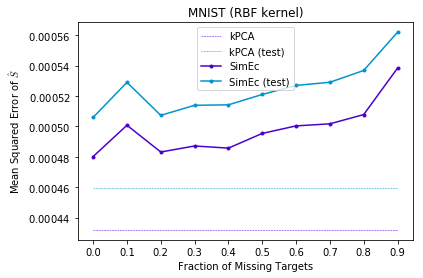

In [30]:
# missing targets
n_targets = 1000
np.random.seed(15)
mse_simec, mse_simec_test = [], []
kpca = KernelPCA(n_components=10, kernel='rbf', gamma=gamma)
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
mse_k = check_similarity_match(X_embed, K_rbf)[0]
mse_kt = check_similarity_match(X_embed_test, K_rbf_test)[0]
missing_targets = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for m in missing_targets:
    print(m)
    K_rbf_noisy = K_rbf.copy()
    K_rbf_noisy[np.random.rand(*K_rbf_noisy.shape)<=m] = -100
    simec = SimilarityEncoder(X.shape[1], 10, n_targets, hidden_layers=[(1000, 'tanh')], 
                              l2_reg=0.00000001, l2_reg_emb=0.00001, l2_reg_out=0.0000001, 
                              mask_value=-100, s_ll_reg=5., S_ll=K_rbf_noisy[:n_targets,:n_targets], 
                              opt=keras.optimizers.Adamax(lr=0.0005))
    simec.fit(X, K_rbf_noisy[:,:n_targets])
    X_embed = simec.transform(X)
    X_embed_test = simec.transform(X_test)
    mse = check_similarity_match(X_embed, K_rbf)[0]
    mse_simec.append(mse)
    mse_t = check_similarity_match(X_embed_test, K_rbf_test)[0]
    mse_simec_test.append(mse_t)
    print("mse kpca: %f (%f); mse simec: %f (%f)" % (mse_k, mse_kt, mse, mse_t))
keras.backend.clear_session()
colors = get_colors(10)
plt.figure();
plt.plot([0, missing_targets[-1]], [mse_k, mse_k], '--', linewidth=0.5, c=colors[8], label='kPCA');
plt.plot([0, missing_targets[-1]], [mse_kt, mse_kt], '--', linewidth=0.5, c=colors[6], label='kPCA (test)');
plt.plot(missing_targets, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(missing_targets, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.title('MNIST (RBF kernel)');
plt.xticks(missing_targets, missing_targets);
plt.xlabel('Fraction of Missing Targets');
plt.ylabel('Mean Squared Error of $\hat{S}$');

## 20 Newsgroups
To show that SimEc embeddings can also be computed for other types of data, we do some further experiments with the 20 newsgroups dataset. We subsample 7 of the 20 categories and remove meta information such as headers to avoid overfitting (see also `http://scikit-learn.org/stable/datasets/twenty_newsgroups.html`). The posts are transformed into very high dimensional tf-idf vectors used as input to the SimEc and to compute the linear kernel matrix.

In [31]:
## load the data and transform it into a tf-idf representation
categories = [
    "comp.graphics",
    "rec.autos",
    "rec.sport.baseball",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns"
]
newsgroups_train = fetch_20newsgroups(subset='train', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
# store in dicts (if the text contains more than 3 words)
textdict = {i: t for i, t in enumerate(newsgroups_train.data) if len(t.split()) > 3}
textdict.update({i: t for i, t in enumerate(newsgroups_test.data, len(newsgroups_train.data)) if len(t.split()) > 3})
train_ids = [i for i in range(len(newsgroups_train.data)) if i in textdict]
test_ids = [i for i in range(len(newsgroups_train.data), len(textdict)) if i in textdict]
print("%i training and %i test samples" % (len(train_ids), len(test_ids)))
# transform into tf-idf features
ft = FeatureTransform(norm='max', weight=True, renorm='max')
docfeats = ft.texts2features(textdict, fit_ids=train_ids)
# organize in feature matrix
X, featurenames = features2mat(docfeats, train_ids)
X_test, _ = features2mat(docfeats, test_ids, featurenames)
print("%i features" % len(featurenames))
targets = np.hstack([newsgroups_train.target,newsgroups_test.target])
y = targets[train_ids]
y_test = targets[test_ids]
target_names = newsgroups_train.target_names
n_targets = 1000

3959 training and 2359 test samples
45813 features


### Linear Similarity
Again, linear kPCA and SimEc give the same solution (up to a rotation). Btw, here we can't use regular PCA as the covariance matrix would be very high dimensional and poorly estimated due to the small amount of samples.

similarity approximation       : msqe: 0.0331868908 ; r^2: 0.2263374840 ; rho: 0.6310964767
similarity approximation (test): msqe: 0.0421617582 ; r^2: 0.1775899837 ; rho: 0.6165146584


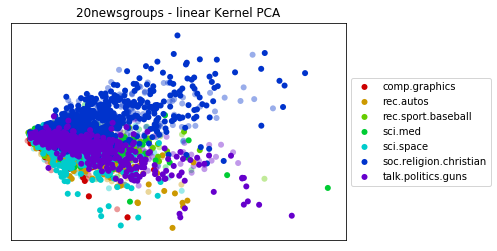

In [32]:
# linear kPCA
kpca = KernelPCA(n_components=2, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
plot_20news(X_embed, y, target_names, X_embed_test, y_test,
            title='20newsgroups - linear Kernel PCA', legend=True)
if savefigs: plt.savefig('fig_spectral_20news_lin_kpca.png', dpi=300)
# compute linear kernel and center
K_lin = center_K(X.dot(X.T).A)
K_lin_test = center_K(X_test.dot(X_test.T).A)
print("similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_lin))
print("similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_test, K_lin_test))

Epoch 1/25
3959/3959 [==============================] - 1s 168us/step - loss: 0.0839
Epoch 2/25
3959/3959 [==============================] - 0s 120us/step - loss: 0.0793
Epoch 3/25
3959/3959 [==============================] - 0s 115us/step - loss: 0.0782
Epoch 4/25
3959/3959 [==============================] - 0s 123us/step - loss: 0.0773
Epoch 5/25
3959/3959 [==============================] - 0s 117us/step - loss: 0.0767
Epoch 6/25
3959/3959 [==============================] - 0s 121us/step - loss: 0.0763
Epoch 7/25
3959/3959 [==============================] - 1s 130us/step - loss: 0.0759
Epoch 8/25
3959/3959 [==============================] - 0s 126us/step - loss: 0.0756
Epoch 9/25
3959/3959 [==============================] - 0s 121us/step - loss: 0.0754
Epoch 10/25
3959/3959 [==============================] - 0s 126us/step - loss: 0.0752
Epoch 11/25
3959/3959 [==============================] - 1s 132us/step - loss: 0.0751
Epoch 12/25
3959/3959 [==============================] - 1s 127

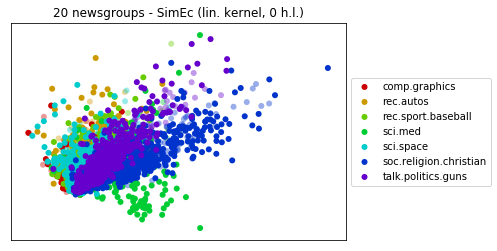

In [33]:
# project to 2d with linear similarity encoder
n_targets = 1000
simec = SimilarityEncoder(X.shape[1], 2, n_targets, sparse_inputs=True, l2_reg_emb=0.00001, 
                          l2_reg_out=0.00000001, s_ll_reg=0.5, S_ll=K_lin[:n_targets,:n_targets],
                          opt=keras.optimizers.Adamax(lr=0.005))
simec.fit(X, K_lin[:,:n_targets])
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot_20news(X_embeds, y, target_names, X_embed_tests, y_test,
            title='20 newsgroups - SimEc (lin. kernel, 0 h.l.)', legend=True)
if savefigs: plt.savefig('fig_spectral_20news_lin_simec.png', dpi=300)
print("correlation with lin kPCA: %f" % check_embed_match(X_embed, X_embeds)[1])
print("correlation with lin kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1])
print("similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_lin))
print("similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_tests, K_lin_test))

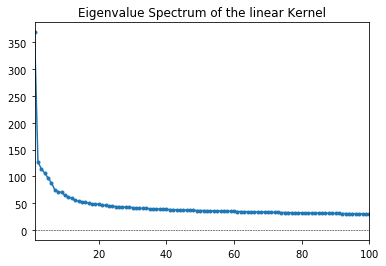

In [34]:
# check how many relevant dimensions there are - obviously at most # feature dim, not # of data points
eigenvals = np.linalg.eigvalsh(K_lin)[::-1]
plt.figure();
plt.plot(list(range(1, K_lin.shape[0]+1)), eigenvals, '-o', markersize=3);
plt.plot([1, K_lin.shape[0]],[0,0], 'k--', linewidth=0.5);
plt.xlim(1, 100);
plt.title('Eigenvalue Spectrum of the linear Kernel');

2
Epoch 1/25
3959/3959 [==============================] - 1s 168us/step - loss: 0.0837
Epoch 2/25
3959/3959 [==============================] - 0s 122us/step - loss: 0.0791
Epoch 3/25
3959/3959 [==============================] - 0s 120us/step - loss: 0.0780
Epoch 4/25
3959/3959 [==============================] - 0s 126us/step - loss: 0.0772
Epoch 5/25
3959/3959 [==============================] - 0s 121us/step - loss: 0.0766
Epoch 6/25
3959/3959 [==============================] - 0s 122us/step - loss: 0.0761
Epoch 7/25
3959/3959 [==============================] - 0s 126us/step - loss: 0.0758
Epoch 8/25
3959/3959 [==============================] - 0s 126us/step - loss: 0.0756
Epoch 9/25
3959/3959 [==============================] - 0s 119us/step - loss: 0.0754
Epoch 10/25
3959/3959 [==============================] - 0s 117us/step - loss: 0.0752
Epoch 11/25
3959/3959 [==============================] - 0s 115us/step - loss: 0.0751
Epoch 12/25
3959/3959 [==============================] - 0s 1

3959/3959 [==============================] - 1s 294us/step - loss: 0.0531
Epoch 5/25
3959/3959 [==============================] - 1s 296us/step - loss: 0.0514
Epoch 6/25
3959/3959 [==============================] - 1s 298us/step - loss: 0.0500
Epoch 7/25
3959/3959 [==============================] - 1s 290us/step - loss: 0.0490
Epoch 8/25
3959/3959 [==============================] - 1s 298us/step - loss: 0.0482
Epoch 9/25
3959/3959 [==============================] - 1s 293us/step - loss: 0.0474
Epoch 10/25
3959/3959 [==============================] - 1s 296us/step - loss: 0.0466
Epoch 11/25
3959/3959 [==============================] - 1s 298us/step - loss: 0.0460
Epoch 12/25
3959/3959 [==============================] - 1s 298us/step - loss: 0.0456
Epoch 13/25
3959/3959 [==============================] - 1s 294us/step - loss: 0.0451
Epoch 14/25
3959/3959 [==============================] - 1s 299us/step - loss: 0.0446
Epoch 15/25
3959/3959 [==============================] - 1s 300us/step 

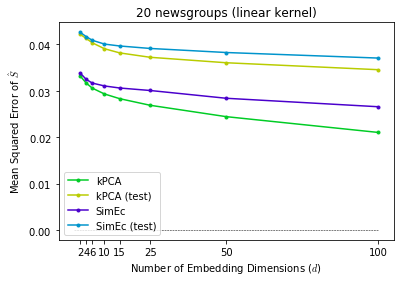

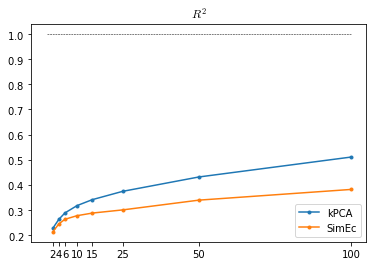

In [35]:
mse_kpca, mse_kpca_test, rsq_kpca = [], [], []
mse_simec, mse_simec_test, rsq_simec = [], [], []
e_dims = [2, 4, 6, 10, 15, 25, 50, 100]
for e_dim in e_dims:
    print(e_dim)
    kpca = KernelPCA(n_components=e_dim, kernel='linear')
    X_embed = kpca.fit_transform(X)
    X_embed_test = kpca.transform(X_test)
    mse_k, rsq, _ = check_similarity_match(X_embed, K_lin)
    mse_kpca.append(mse_k)
    rsq_kpca.append(rsq)
    mse_kt, _, _ = check_similarity_match(X_embed_test, K_lin_test)
    mse_kpca_test.append(mse_kt)
    simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, sparse_inputs=True, l2_reg_emb=0.00001, 
                              l2_reg_out=0.00000001, s_ll_reg=0.5, S_ll=K_lin[:n_targets,:n_targets],
                              opt=keras.optimizers.Adamax(lr=0.005))
    simec.fit(X, K_lin[:,:n_targets])
    X_embeds = simec.transform(X)
    X_embed_tests = simec.transform(X_test)
    mse, rsq, _ = check_similarity_match(X_embeds, K_lin)
    mse_simec.append(mse)
    rsq_simec.append(rsq)
    mse_t, _, _ = check_similarity_match(X_embed_tests, K_lin_test)
    mse_simec_test.append(mse_t)
    print("mse kpca: %f (%f); mse simec: %f (%f)" % (mse_k, mse_kt, mse, mse_t))
    print("correlation with linear kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1])
    print("correlation with linear kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1])
keras.backend.clear_session()
colors = get_colors(10)
plt.figure();
plt.plot(e_dims, mse_kpca, '-o', markersize=3, c=colors[4], label='kPCA');
plt.plot(e_dims, mse_kpca_test, '-o', markersize=3, c=colors[2], label='kPCA (test)');
plt.plot(e_dims, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(e_dims, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=3);
plt.title('20 newsgroups (linear kernel)');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions ($d$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print("e_dims=", e_dims)
print("mse_kpca=", mse_kpca)
print("mse_kpca_test=", mse_kpca_test)
print("mse_simec=", mse_simec)
print("mse_simec_test=", mse_simec_test)
if savefigs: plt.savefig('fig_spectral_20news_lin_mse_edim.pdf', dpi=300)
plt.figure();
plt.plot(e_dims, rsq_kpca, '-o', markersize=3, label='kPCA');
plt.plot(e_dims, rsq_simec, '-o', markersize=3, label='SimEc');
plt.plot([0, e_dims[-1]], [1,1], 'k--', linewidth=0.5);
plt.legend(loc=0);
plt.title('$R^2$');
plt.xticks(e_dims, e_dims);

100
Epoch 1/25
3959/3959 [==============================] - 1s 153us/step - loss: 0.4639
Epoch 2/25
3959/3959 [==============================] - 0s 116us/step - loss: 0.4077
Epoch 3/25
3959/3959 [==============================] - 0s 121us/step - loss: 0.3785
Epoch 4/25
3959/3959 [==============================] - 0s 118us/step - loss: 0.3596
Epoch 5/25
3959/3959 [==============================] - 0s 122us/step - loss: 0.3461
Epoch 6/25
3959/3959 [==============================] - 0s 116us/step - loss: 0.3357
Epoch 7/25
3959/3959 [==============================] - 0s 119us/step - loss: 0.3272
Epoch 8/25
3959/3959 [==============================] - 0s 116us/step - loss: 0.3198
Epoch 9/25
3959/3959 [==============================] - 0s 123us/step - loss: 0.3135
Epoch 10/25
3959/3959 [==============================] - 0s 116us/step - loss: 0.3081
Epoch 11/25
3959/3959 [==============================] - 0s 123us/step - loss: 0.3036
Epoch 12/25
3959/3959 [==============================] - 0s

Epoch 16/25
3959/3959 [==============================] - 0s 116us/step - loss: 0.0797
Epoch 17/25
3959/3959 [==============================] - 0s 123us/step - loss: 0.0796
Epoch 18/25
3959/3959 [==============================] - 0s 125us/step - loss: 0.0795
Epoch 19/25
3959/3959 [==============================] - 0s 124us/step - loss: 0.0793
Epoch 20/25
3959/3959 [==============================] - 0s 118us/step - loss: 0.0793
Epoch 21/25
3959/3959 [==============================] - 1s 127us/step - loss: 0.0792
Epoch 22/25
3959/3959 [==============================] - 0s 124us/step - loss: 0.0790
Epoch 23/25
3959/3959 [==============================] - 0s 126us/step - loss: 0.0789
Epoch 24/25
3959/3959 [==============================] - 0s 116us/step - loss: 0.0789
Epoch 25/25
3959/3959 [==============================] - 0s 121us/step - loss: 0.0789
mse kpca: 0.029294 (0.039042); mse simec: 0.031308 (0.040456)
correlation with linear kPCA       : 0.804652
correlation with linear kPCA (te

3959/3959 [==============================] - 1s 354us/step - loss: 0.0491
Epoch 5/25
3959/3959 [==============================] - 1s 352us/step - loss: 0.0484
Epoch 6/25
3959/3959 [==============================] - 1s 349us/step - loss: 0.0478
Epoch 7/25
3959/3959 [==============================] - 1s 345us/step - loss: 0.0472
Epoch 8/25
3959/3959 [==============================] - 1s 348us/step - loss: 0.0468
Epoch 9/25
3959/3959 [==============================] - 1s 347us/step - loss: 0.0464
Epoch 10/25
3959/3959 [==============================] - 1s 350us/step - loss: 0.0462
Epoch 11/25
3959/3959 [==============================] - 1s 352us/step - loss: 0.0459
Epoch 12/25
3959/3959 [==============================] - 1s 340us/step - loss: 0.0458
Epoch 13/25
3959/3959 [==============================] - 1s 352us/step - loss: 0.0456
Epoch 14/25
3959/3959 [==============================] - 1s 350us/step - loss: 0.0454
Epoch 15/25
3959/3959 [==============================] - 1s 350us/step 

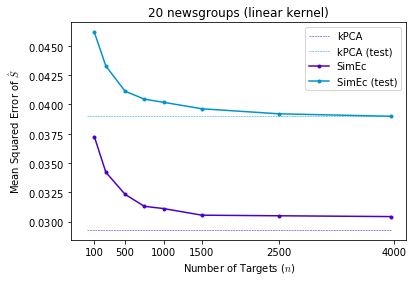

In [36]:
# check effect of different number of targets
mse_simec, mse_simec_test = [], []
targets = [100, 250, 500, 750, 1000, 1500, 2500, K_lin.shape[1]]
e_dim = 10
kpca = KernelPCA(n_components=e_dim, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
mse_k, _, _ = check_similarity_match(X_embed, K_lin)
mse_kt, _, _ = check_similarity_match(X_embed_test, K_lin_test)
for n in targets:
    print(n)
    simec = SimilarityEncoder(X.shape[1], e_dim, n, sparse_inputs=True, l2_reg_emb=0.00001, 
                              l2_reg_out=0.00000001, s_ll_reg=0.5, S_ll=K_lin[:n,:n],
                              opt=keras.optimizers.Adamax(lr=0.005))
    simec.fit(X, K_lin[:,:n])
    X_embeds = simec.transform(X)
    X_embed_tests = simec.transform(X_test)
    mse, _, _ = check_similarity_match(X_embeds, K_lin)
    mse_simec.append(mse)
    mse_t, _, _ = check_similarity_match(X_embed_tests, K_lin_test)
    mse_simec_test.append(mse_t)
    print("mse kpca: %f (%f); mse simec: %f (%f)" % (mse_k, mse_kt, mse, mse_t))
    print("correlation with linear kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1])
    print("correlation with linear kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1])
colors = get_colors(10)
plt.figure();
plt.plot([0, targets[-1]], [mse_k, mse_k], '--', linewidth=0.5, c=colors[8], label='kPCA');
plt.plot([0, targets[-1]], [mse_kt, mse_kt], '--', linewidth=0.5, c=colors[6], label='kPCA (test)');
plt.plot(targets, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(targets, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.title('20 newsgroups (linear kernel)');
plt.xticks([100, 500, 1000, 1500, 2500, 4000], [100, 500, 1000, 1500, 2500, 4000]);
plt.xlabel('Number of Targets ($n$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print("targets=", targets)
print("mse_k=", mse_k)
print("mse_kt=", mse_kt)
print("mse_simec=", mse_simec)
print("mse_simec_test=", mse_simec_test)
if savefigs: plt.savefig('fig_spectral_20news_lin_mse_ntargets.pdf', dpi=300)

0.0
Epoch 1/25
3959/3959 [==============================] - 1s 211us/step - loss: 0.0801
Epoch 2/25
3959/3959 [==============================] - 1s 140us/step - loss: 0.0754
Epoch 3/25
3959/3959 [==============================] - 1s 140us/step - loss: 0.0733
Epoch 4/25
3959/3959 [==============================] - 1s 138us/step - loss: 0.0721
Epoch 5/25
3959/3959 [==============================] - 1s 132us/step - loss: 0.0713
Epoch 6/25
3959/3959 [==============================] - 1s 134us/step - loss: 0.0708
Epoch 7/25
3959/3959 [==============================] - 1s 128us/step - loss: 0.0703
Epoch 8/25
3959/3959 [==============================] - 1s 138us/step - loss: 0.0699
Epoch 9/25
3959/3959 [==============================] - 1s 142us/step - loss: 0.0696
Epoch 10/25
3959/3959 [==============================] - 1s 139us/step - loss: 0.0693
Epoch 11/25
3959/3959 [==============================] - 1s 136us/step - loss: 0.0691
Epoch 12/25
3959/3959 [==============================] - 1s

3959/3959 [==============================] - 1s 137us/step - loss: 0.0674
Epoch 12/25
3959/3959 [==============================] - 1s 137us/step - loss: 0.0670
Epoch 13/25
3959/3959 [==============================] - 1s 132us/step - loss: 0.0667
Epoch 14/25
3959/3959 [==============================] - 1s 143us/step - loss: 0.0663
Epoch 15/25
3959/3959 [==============================] - 1s 135us/step - loss: 0.0660
Epoch 16/25
3959/3959 [==============================] - 1s 132us/step - loss: 0.0658
Epoch 17/25
3959/3959 [==============================] - 1s 138us/step - loss: 0.0654
Epoch 18/25
3959/3959 [==============================] - 1s 132us/step - loss: 0.0652
Epoch 19/25
3959/3959 [==============================] - 1s 138us/step - loss: 0.0649
Epoch 20/25
3959/3959 [==============================] - 1s 141us/step - loss: 0.0647
Epoch 21/25
3959/3959 [==============================] - 1s 137us/step - loss: 0.0644
Epoch 22/25
3959/3959 [==============================] - 1s 142us/

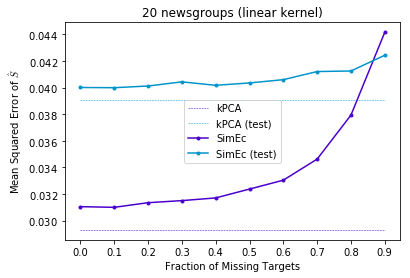

In [37]:
# check effect of missing target values
n_targets = 1000
np.random.seed(10)
mse_simec, mse_simec_test = [], []
kpca = KernelPCA(n_components=10, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
mse_k = check_similarity_match(X_embed, K_lin)[0]
mse_kt = check_similarity_match(X_embed_test, K_lin_test)[0]
missing_targets = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for m in missing_targets:
    print(m)
    K_lin_noisy = K_lin.copy()
    K_lin_noisy[np.random.rand(*K_lin_noisy.shape)<=m] = -100
    simec = SimilarityEncoder(X.shape[1], 10, n_targets, mask_value=-100, sparse_inputs=True, l2_reg_emb=0.00001, 
                              l2_reg_out=0.00000001, s_ll_reg=0.5, S_ll=K_lin_noisy[:n_targets,:n_targets],
                              opt=keras.optimizers.Adamax(lr=0.005))
    simec.fit(X, K_lin_noisy[:,:n_targets])
    X_embed = simec.transform(X)
    X_embed_test = simec.transform(X_test)
    mse = check_similarity_match(X_embed, K_lin)[0]
    mse_simec.append(mse)
    mse_t = check_similarity_match(X_embed_test, K_lin_test)[0]
    mse_simec_test.append(mse_t)
    print("mse kpca: %f (%f); mse simec: %f (%f)" % (mse_k, mse_kt, mse, mse_t))
keras.backend.clear_session()
colors = get_colors(10)
plt.figure();
plt.plot([0, missing_targets[-1]], [mse_k, mse_k], '--', linewidth=0.5, c=colors[8], label='kPCA');
plt.plot([0, missing_targets[-1]], [mse_kt, mse_kt], '--', linewidth=0.5, c=colors[6], label='kPCA (test)');
plt.plot(missing_targets, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(missing_targets, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.title('20 newsgroups (linear kernel)');
plt.xticks(missing_targets, missing_targets);
plt.xlabel('Fraction of Missing Targets')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print("missing_targets=", missing_targets)
print("mse_k=", mse_k)
print("mse_kt=", mse_kt)
print("mse_simec=", mse_simec)
print("mse_simec_test=", mse_simec_test)
if savefigs: plt.savefig('fig_spectral_20news_lin_mse_missingt.pdf', dpi=300)